In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [ ]:
cd /content/drive/MyDrive/Jobs_Recomm

/content/drive/MyDrive/Jobs_Recomm


In [ ]:
apps = pd.read_csv('input_data/apps.tsv', delimiter='\t',encoding='utf-8')
user_history = pd.read_csv('input_data/user_history.tsv', delimiter='\t',encoding='utf-8')
jobs = pd.read_csv('/content/jobs.tsv', delimiter='\t',encoding='utf-8', on_bad_lines="skip")
users = pd.read_csv('input_data/users.tsv' ,delimiter='\t',encoding='utf-8')
test_users = pd.read_csv('input_data/test_users.tsv', delimiter='\t',encoding='utf-8')

In [ ]:
user_history.head()

,UserID,WindowID,Split,Sequence,JobTitle
0,47,1,Train,1,National Space Communication Programs-Special ...
1,47,1,Train,2,Detention Officer
2,47,1,Train,3,"Passenger Screener, TSA"
3,72,1,Train,1,"Lecturer, Department of Anthropology"
4,72,1,Train,2,Student Assistant


In [ ]:
jobs.columns

Index(['JobID', 'WindowID', 'Title', 'Description', 'Requirements', 'City',
       'State', 'Country', 'Zip5', 'StartDate', 'EndDate'],
      dtype='object')

In [ ]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5931 entries, 0 to 5930
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   JobID         5931 non-null   int64 
 1   WindowID      5931 non-null   int64 
 2   Title         5931 non-null   object
 3   Description   5931 non-null   object
 4   Requirements  5774 non-null   object
 5   City          5930 non-null   object
 6   State         5930 non-null   object
 7   Country       5929 non-null   object
 8   Zip5          3180 non-null   object
 9   StartDate     5930 non-null   object
 10  EndDate       5929 non-null   object
dtypes: int64(2), object(9)
memory usage: 509.8+ KB


**Pre-process**

There are 3 files which we require to split into training and test sets -
1. apps
2. user_history
3. users

In [ ]:
apps_training = apps.loc[apps['Split'] == 'Train']
apps_testing = apps.loc[apps['Split'] == 'Test']

In [ ]:
apps_training.head()

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


In [ ]:
user_history_training = user_history.loc[user_history['Split'] =='Train']
user_history_testing = user_history.loc[user_history['Split'] =='Test']

users_training = users.loc[users['Split']=='Train']
users_testing = users.loc[users['Split']=='Test']

In [ ]:
jobs.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59


In [ ]:
import re

removePattern = r'(<(.*?)>)|(&\w+)'
addSpacePattern = r'([;:])|(\\r)|(\\n)'
removeExtraSpaces = r'(\s\s+?)(?=\S)'

jobs['DescCleaned'] = jobs['Description'].astype(str).str.lower()
jobs['DescCleaned'] = jobs['DescCleaned'].apply(lambda x: re.sub(removePattern, "", x))
jobs['DescCleaned'] = jobs['DescCleaned'].apply(lambda x: re.sub(addSpacePattern, " ", x))
jobs['DescCleaned'] = jobs['DescCleaned'].apply(lambda x: re.sub(removeExtraSpaces, " ", x))
# Similarly for requirements
jobs['ReqCleaned'] = jobs['Requirements'].astype(str).str.lower()
jobs['ReqCleaned'] = jobs['ReqCleaned'].apply(lambda x: re.sub(removePattern, "", x))
jobs['ReqCleaned'] = jobs['ReqCleaned'].apply(lambda x: re.sub(addSpacePattern, " ", x))
jobs['ReqCleaned'] = jobs['ReqCleaned'].apply(lambda x: re.sub(removeExtraSpaces, " ", x))


In [ ]:
jobs.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate,DescCleaned,ReqCleaned
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59,security clearance required top secret job num...,skill set network security tools webdefend web...
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59,no corp. to corp resumes are being considered ...,what you need four year college degree minimum...
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59,p/t human resources assistant —— 1-2 years ex...,please refer to the job description to view th...
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59,city beverages come to work for the best in th...,please refer to the job description to view th...
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59,i make sure every part of their day is magical...,please refer to the job description to view th...


In [ ]:
jobs.at[0, 'ReqCleaned']

'skill set network security tools webdefend web application firewall (waf), cisco routers, fortigate 3800 firewall series, palo alto 4000 firewall series, cisco asa 5xx firewall platform, cisco fwsm, sourcefire defense center, sourcefire ip sensor platform, bluecoat sg appliance, f5 bigip(reverse proxy). web application tools appdective, fortify sca, hp webinspect, and the like. network vulnerability tools tenable security center, mcafee foundstone scanner, cain and able, l0phtcrack - password cracker, nessus vulnerability scanner, nmap port scanner, and other scanning and vulnerability mapping tools. desirable skills cissp and/or related certifications education and years of experience bs computer science or related discipline minimum of 8 years in it security minimum 4 years in senior/lead position apply here'

In [ ]:
jobs.groupby(['City','State','Country']).size().reset_index(name='Locationwise')

,City,State,Country,Locationwise
0,Abington,PA,US,1
1,Absecon,NJ,US,2
2,Agawam,MA,US,1
3,Aiken,SC,US,2
4,Akron,OH,US,10
...,...,...,...,...
1670,Yorba Linda,CA,US,1
1671,York,PA,US,4
1672,Yorktown Heights,NY,US,1
1673,Zanesville,OH,US,1


In [ ]:
jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise', ascending=False).head()

,Country,Locationwise
2,US,5927
0,AF,1
1,MX,1


In [ ]:
Country_wise_job = jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                                    ascending=False)

<ipython-input-26-608f400eab43>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")


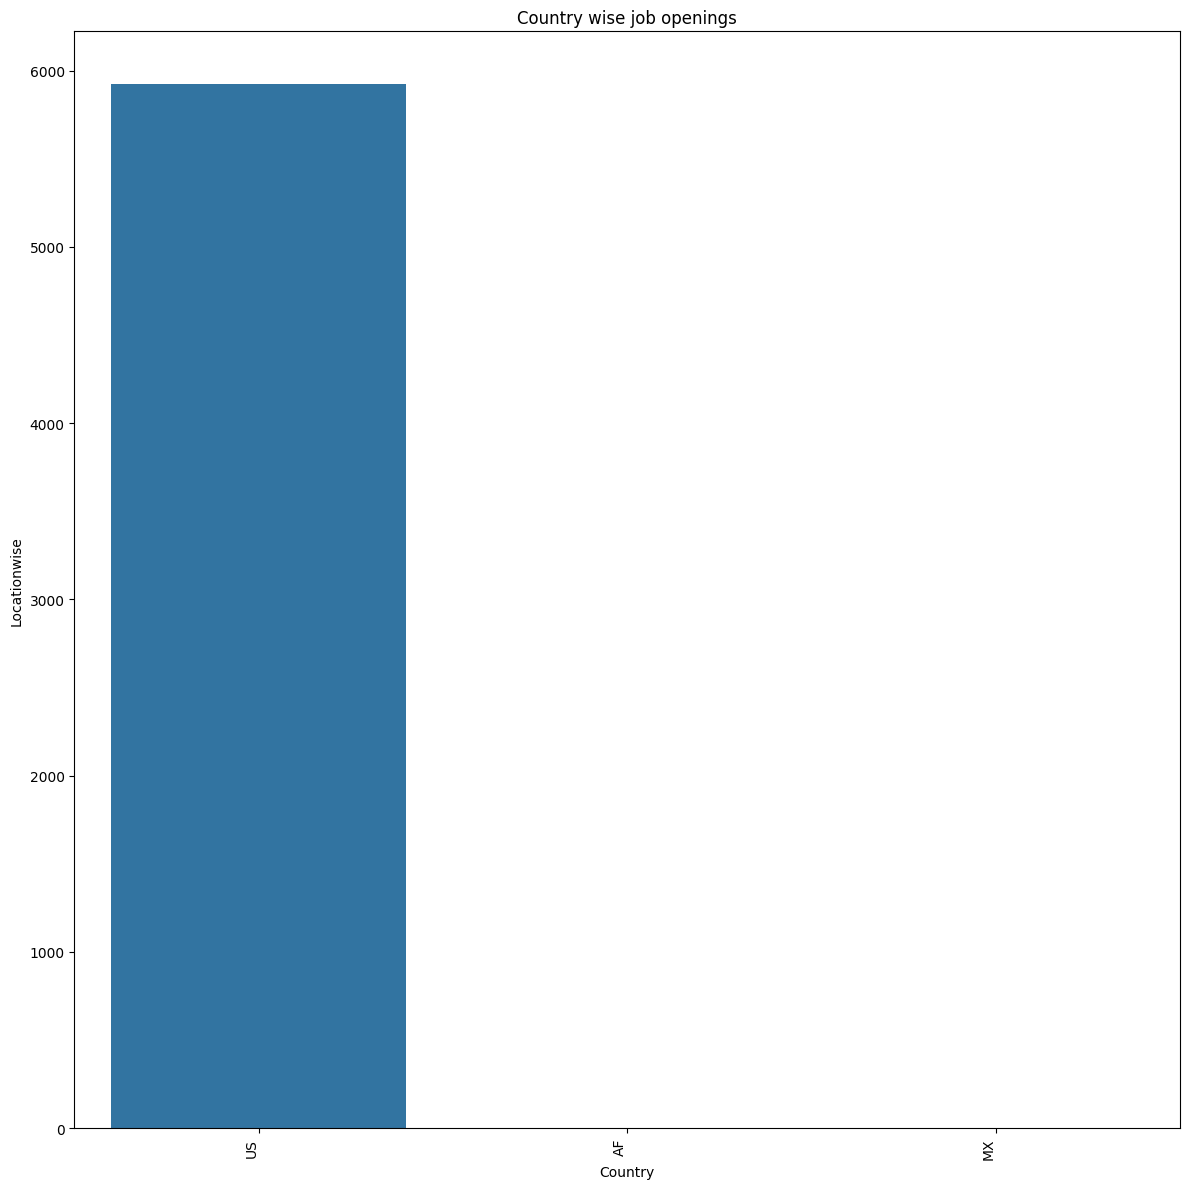

In [ ]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="Country", y="Locationwise", data=Country_wise_job)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('Country wise job openings')
plt.tight_layout()
plt.show()

As we can see above, almost all of the jobs are present in the united states.
Thus, we will only consider jobs in the United States and remove any noise in the dataset. <br>
In below, I will be doing 3 things ->

1. I will remove the city column as it is not really very important and has a lot of noise
2. I will remove the data points which have state as NULL or as numbers
3. I will be considering only US as the country         

In [ ]:
jobs = jobs.loc[jobs['Country']=='US']
jobs.drop(columns=['City'])

,JobID,WindowID,Title,Description,Requirements,State,Country,Zip5,StartDate,EndDate,DescCleaned,ReqCleaned
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59,security clearance required top secret job num...,skill set network security tools webdefend web...
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59,no corp. to corp resumes are being considered ...,what you need four year college degree minimum...
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59,p/t human resources assistant —— 1-2 years ex...,please refer to the job description to view th...
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59,city beverages come to work for the best in th...,please refer to the job description to view th...
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59,i make sure every part of their day is magical...,please refer to the job description to view th...
...,...,...,...,...,...,...,...,...,...,...,...,...
5925,22384,1,"Sales Account Manager, Library & Higher Education","<p>&nbsp;</p>\r<p align=""center"">&nbsp;<b><spa...",<p><span>To qualify you must have:</span></p>\...,WA,US,NaN,2012-03-02 16:15:37.443,2012-04-01 23:59:59,"sales account manager, library and college ma...",to qualify you must have 3+ years experience s...
5926,22385,1,"Sales Account Manager, Library & Higher Education","<p>&nbsp;</p>\r<p align=""center"">&nbsp;<b><spa...",<span>\r<p><span>To qualify you must have:</sp...,AZ,US,NaN,2012-03-02 16:19:20.953,2012-04-01 23:59:59,"sales account manager, library and college ma...",to qualify you must have 3+ years experience ...
5927,22389,1,Systems Manager,Serves as subject matter expert and leader and...,Required Skills / Qualifications:\r\n \r\nMini...,GA,US,30117,2012-03-13 16:28:24.203,2012-04-12 23:59:59,serves as subject matter expert and leader and...,required skills / qualifications minimum of 2 ...
5928,22394,1,Business Analyst,Seeking an experienced Business Analyst with s...,Required Skills / Qualifications:\r\n• Bachelo...,NY,US,12204,2012-03-13 07:23:38.307,2012-04-12 23:59:59,seeking an experienced business analyst with s...,required skills / qualifications • bachelor's ...


In [ ]:
# Recommendations

In [ ]:
jobs.columns

Index(['JobID', 'WindowID', 'Title', 'Description', 'Requirements', 'City',
       'State', 'Country', 'Zip5', 'StartDate', 'EndDate', 'DescCleaned',
       'ReqCleaned'],
      dtype='object')

In [ ]:
jobs.head().transpose()

,0,1,2,3,4
JobID,1,4,7,8,9
WindowID,1,1,1,1,1
Title,Security Engineer/Technical Lead,SAP Business Analyst / WM,P/T HUMAN RESOURCES ASSISTANT,Route Delivery Drivers,Housekeeping
Description,<p>Security Clearance Required:&nbsp; Top Secr...,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,CITY BEVERAGES Come to work for the best in th...,I make sure every part of their day is magica...
Requirements,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Please refer to the Job Description to view th...,Please refer to the Job Description to view th...,Please refer to the Job Description to view th...
City,Washington,Charlotte,Winter Park,Orlando,Orlando
State,DC,NC,FL,FL,FL
Country,US,US,US,US,US
Zip5,20531,28217,32792,NaN,NaN
StartDate,2012-03-07 13:17:01.643,2012-03-21 02:03:44.137,2012-03-02 16:36:55.447,2012-03-03 09:01:10.077,2012-03-03 09:01:11.88


In [ ]:
jobs_US_base_line = jobs.iloc[0:10000,0:8]

In [ ]:
jobs_US_base_line.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US


In [ ]:
jobs_US_base_line['Title'] = jobs_US_base_line['Title'].fillna('')
jobs_US_base_line['Description'] = jobs_US_base_line['Description'].fillna('')
jobs_US_base_line['Description'] = jobs_US_base_line['Title'] + jobs_US_base_line['Description']

In [ ]:
users_training.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [ ]:


user_based_approach_US = users_training.loc[users_training['Country']=='US']



In [ ]:
user_based_approach = user_based_approach_US.iloc[0:10000,:]

In [ ]:
user_based_approach.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [ ]:
user_based_approach['DegreeType'] = user_based_approach['DegreeType'].fillna('')
user_based_approach['Major'] = user_based_approach['Major'].fillna('')
user_based_approach['TotalYearsExperience'] = user_based_approach['TotalYearsExperience'].fillna('').astype(str)

user_based_approach['DegreeType'] = user_based_approach['DegreeType'] + ' ' + user_based_approach['Major'] + ' ' + user_based_approach['TotalYearsExperience']


<ipython-input-48-2442046be54e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_based_approach['DegreeType'] = user_based_approach['DegreeType'].fillna('')
<ipython-input-48-2442046be54e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_based_approach['Major'] = user_based_approach['Major'].fillna('')
<ipython-input-48-2442046be54e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [ ]:

user_based_approach['DegreeType'].head()

0                       High School  10.0
1               Master's Anthropology 8.0
2         High School Not Applicable 11.0
3                 Master's Journalism 3.0
4    Bachelor's Agricultural Business 9.0
Name: DegreeType, dtype: object

In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(user_based_approach['DegreeType'])

In [ ]:


tfidf_matrix.shape



(10000, 6104)

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_sim.shape

(10000, 10000)

In [ ]:
user_based_approach = user_based_approach.reset_index()
userid = user_based_approach['UserID']
indices = pd.Series(user_based_approach.index, index=user_based_approach['UserID'])

In [ ]:
def get_recommendations_userwise(userid):
    idx = indices[userid]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    user_indices = [i[0] for i in sim_scores]
    user_indices_top = user_indices[1:12]
    similar_users = list(user_based_approach.loc[indices.iloc[user_indices_top]]['UserID'].values)
    return similar_users

In [ ]:
print ("-----Top 10 Similar users with userId: 123------")
get_recommendations_userwise(47)

-----Top 10 Similar users with userId: 123------


[24893,
 57269,
 57752,
 61840,
 66863,
 101392,
 128514,
 132279,
 142692,
 142857,
 151952]

In [ ]:
apps_training['UserID'].unique()

array([     47,      72,      80, ..., 1472058, 1472060, 1472089])

In [ ]:
def get_job_id(usrid_list):
    jobs_userwise = apps_training['UserID'].isin(usrid_list) #
    df1 = pd.DataFrame(data = apps_training[jobs_userwise], columns=['JobID'])
    joblist = df1['JobID'].tolist()
    Job_list = jobs['JobID'].isin(joblist) #[1083186, 516837, 507614, 754917, 686406, 1058896, 335132])
    df_temp = pd.DataFrame(data = jobs[Job_list], columns=['JobID','Title','Description','City','State'])
    return df_temp

In [ ]:
get_job_id(get_recommendations_userwise(80))

,JobID,Title,Description,City,State
113,370,Domestic Violence,Domestic Violence and Traumatic Brain Injury P...,Tallahassee,FL
244,780,Trainer-Security,<p>Trainer-Security </p> <p> CB329181 Chicago...,Chicago,IL
2504,10312,Receptionist,<span>To assist all departments in the dealers...,Arlington,TX
2783,11383,Accounting,Accounting<br />\r<hr>\rAP/AR/GL<br />\r<br />...,Tallahassee,FL
2854,11623,Receptionist/HR Assistant,"<p><span>Operates system switchboard, </span><...",Mansfield,TX
3300,13313,Office Assistant,"<P style=""TEXT-ALIGN: center"" align=center><SP...",Chicago,IL
3476,13911,Shipping Coordinator,<p><b>SUMMARY - SHIPPING COORDINATOR</b></p>\r...,Petersburg,VA
3585,14362,Various Positions,"<p style=""text-align: center"" align=""center""><...",Tallahassee,FL
4127,16394,Part Time Sales Rep - Salon Consultant,<P><STRONG>Beauty Systems Group</STRONG> (a di...,Tallahassee,FL
4434,17624,Content Specialist/Copywriter,<p><strong><span>Director of Content Marketing...,Tallahassee,FL
